# MACD

在MACD_1的基础上进行调参，调整成交量对趋势的判断部分，最终实现Sharpe Ratio：1.6，总收益率：0.38%，百分比最大回撤: -0.27%

## 配置引擎参数

In [43]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [44]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 1             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-3]-MACD[-4])/MACD[-4]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.2) and (diff_MACD_2>0) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.2) and (diff_MACD_2<0) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [45]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x00000221922E4598>, <__main__.MACDStrategy object at 0x00000221909D7C18>)
2018-12-19 11:32:42.127281	开始回测
2018-12-19 11:32:42.128278	策略初始化
2018-12-19 11:32:42.130272	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-19 11:32:43.072903	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 11:32:43.075893	载入完成，数据量：12000
2018-12-19 11:32:43.075893	策略初始化完成
2018-12-19 11:32:43.075893	策略启动完成
2018-12-19 11:32:43.075893	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 11:32:43.094870	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 11:32:54.004846	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 11:32:54.056711	载入完成，数据量：257407
2018-12-19 11:32:54.056711	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-19 11:32:54.058703	载入历史数据。数据范围:[20180531 08:51,20180603 00:01

In [46]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-02 04:00:00,空,,,0.0,,开仓,1,,7440.14,0.0,None,,,1,2018-06-02 04:00:00,1,1,BTCUSDT:binance,1
2018-06-02 16:00:00,多,,,0.0,,平仓,2,,7641.00,0.0,None,,,2,2018-06-02 16:00:00,1,2,BTCUSDT:binance,2
2018-06-02 16:00:00,多,,,0.0,,开仓,3,,7641.00,0.0,None,,,3,2018-06-02 16:00:00,1,3,BTCUSDT:binance,3
2018-06-05 03:00:00,空,,,0.0,,平仓,4,,7498.00,0.0,None,,,4,2018-06-05 03:00:00,1,4,BTCUSDT:binance,4
2018-06-05 03:00:00,空,,,0.0,,开仓,5,,7498.00,0.0,None,,,5,2018-06-05 03:00:00,1,5,BTCUSDT:binance,5
2018-06-06 22:00:00,多,,,0.0,,平仓,6,,7629.99,0.0,None,,,6,2018-06-06 22:00:00,1,6,BTCUSDT:binance,6
2018-06-06 22:00:00,多,,,0.0,,开仓,7,,7629.99,0.0,None,,,7,2018-06-06 22:00:00,1,7,BTCUSDT:binance,7
2018-06-09 00:00:00,空,,,0.0,,平仓,8,,7633.57,0.0,None,,,8,2018-06-09 00:00:00,1,8,BTCUSDT:binance,8
2018-06-09 00:00:00,空,,,0.0,,开仓,9,,7633.57,0.0,None,,,9,2018-06-09 00:00:00,1,9,BTCUSDT:binance,9


## 查看绩效回测绩效

2018-12-19 11:33:12.141637	计算按日统计结果
2018-12-19 11:33:12.187513	------------------------------
2018-12-19 11:33:12.187513	首个交易日：	2018-06-01 00:00:00
2018-12-19 11:33:12.187513	最后交易日：	2018-11-27 00:00:00
2018-12-19 11:33:12.187513	总交易日：	180
2018-12-19 11:33:12.187513	盈利交易日	95
2018-12-19 11:33:12.187513	亏损交易日：	83
2018-12-19 11:33:12.187513	起始资金：	1000000
2018-12-19 11:33:12.187513	结束资金：	1,003,769.43
2018-12-19 11:33:12.187513	总收益率：	0.38%
2018-12-19 11:33:12.187513	年化收益：	0.5%
2018-12-19 11:33:12.187513	总盈亏：	3,769.43
2018-12-19 11:33:12.187513	最大回撤: 	-2,663.63
2018-12-19 11:33:12.187513	百分比最大回撤: -0.27%
2018-12-19 11:33:12.187513	总手续费：	392.94
2018-12-19 11:33:12.187513	总滑点：	0.23
2018-12-19 11:33:12.188511	总成交金额：	785,873.46
2018-12-19 11:33:12.188511	总成交笔数：	117
2018-12-19 11:33:12.188511	日均盈亏：	20.94
2018-12-19 11:33:12.188511	日均手续费：	2.18
2018-12-19 11:33:12.188511	日均滑点：	0.0
2018-12-19 11:33:12.188511	日均成交金额：	4,365.96
2018-12-19 11:33:12.188511	日均成交笔数：	0.65
2018-12-19 11:33:12.188511	日均收益率：	0.0

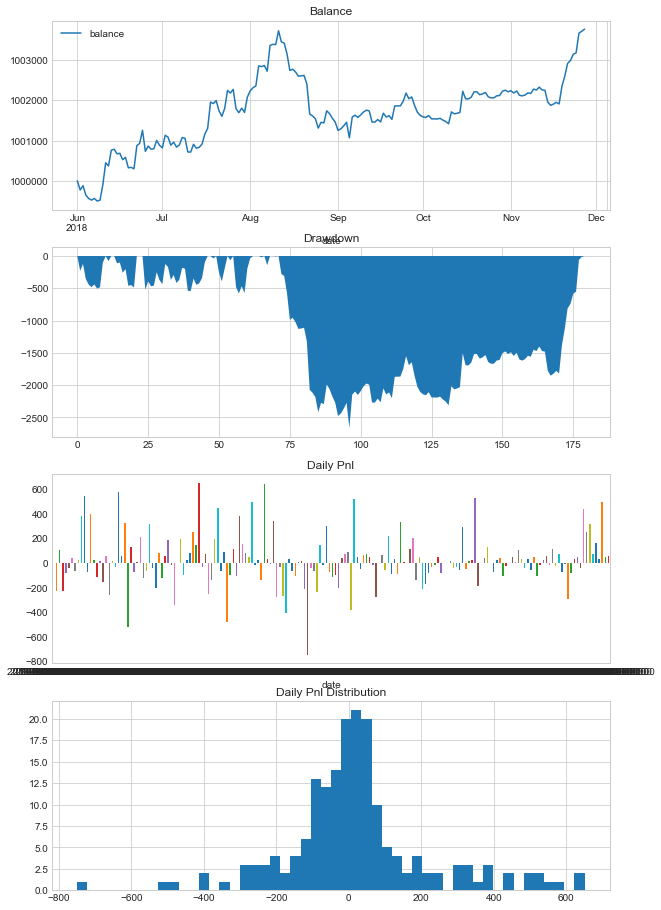

In [47]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-19 11:33:23.419978	计算回测结果
2018-12-19 11:33:23.433940	------------------------------
2018-12-19 11:33:23.433940	第一笔交易：	2018-06-02 16:00:00
2018-12-19 11:33:23.433940	最后一笔交易：	2018-11-27 23:57:00
2018-12-19 11:33:23.433940	总交易次数：	59
2018-12-19 11:33:23.433940	总盈亏：	3,767.54
2018-12-19 11:33:23.433940	最大回撤: 	-2,444.33
2018-12-19 11:33:23.433940	平均每笔盈利：	63.86
2018-12-19 11:33:23.433940	平均每笔滑点：	0.0
2018-12-19 11:33:23.433940	平均每笔佣金：	6.69
2018-12-19 11:33:23.433940	胜率		35.59%
2018-12-19 11:33:23.433940	盈利交易平均值	450.09
2018-12-19 11:33:23.433940	亏损交易平均值	-149.59
2018-12-19 11:33:23.433940	盈亏比：	3.01


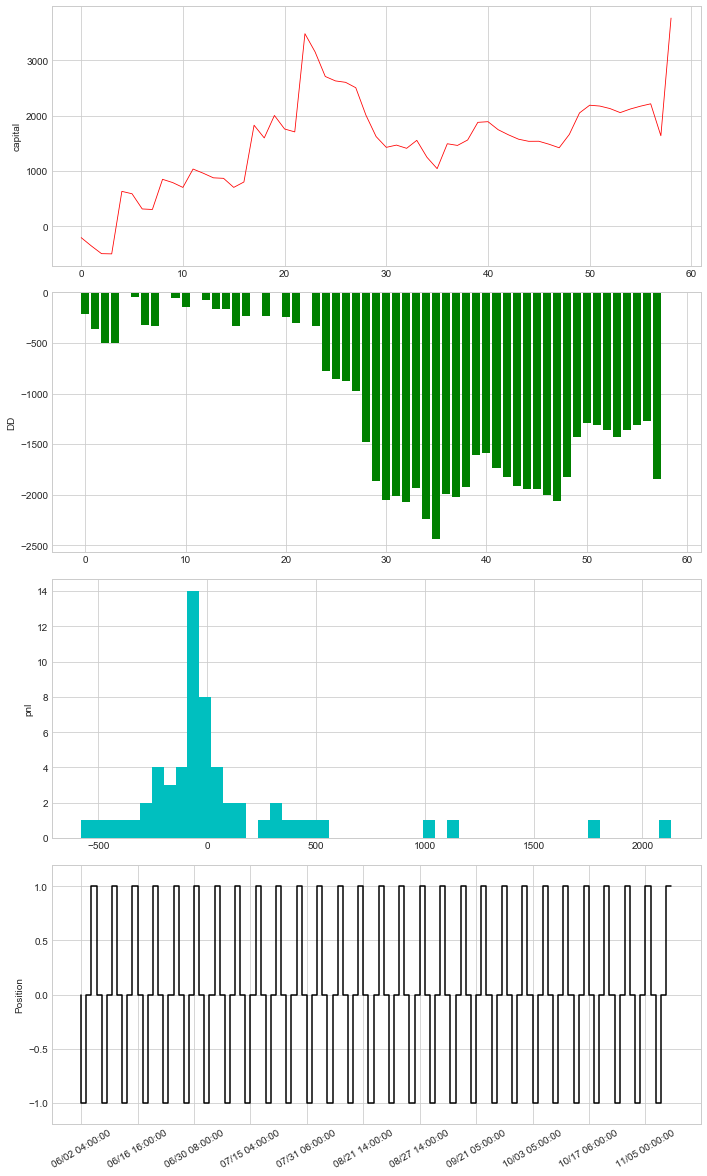

In [48]:
# 显示逐笔回测结果
engine.showBacktestingResult()


In [ ]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

In [ ]:
print(pd.Series(result)) # 显示绩效指标

In [116]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod_v', 2, 7, 1)    # 
setting.addParameter('slowPeriod_v', 8, 16, 2)    # 
# setting.addParameter('signalMaPeriod', 10, 20, 5)    # 增加第二个优化参数，起始10，结束30，步进5

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MACDStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-19 10:04:06.661601	------------------------------
2018-12-19 10:04:06.661601	setting: {'fastPeriod_v': 2, 'slowPeriod_v': 8, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x00000179089810D0>, <__main__.MACDStrategy object at 0x000001790B232F60>)
2018-12-19 10:04:06.695508	开始回测
2018-12-19 10:04:06.695508	策略初始化
2018-12-19 10:04:06.696533	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-19 10:04:07.224018	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:04:07.227041	载入完成，数据量：12000
2018-12-19 10:04:07.227041	策略初始化完成
2018-12-19 10:04:07.227041	策略启动完成
2018-12-19 10:04:07.227041	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:04:07.245961	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:04:18.406012	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:04:18.463855	载入完成，数据量：257407
2018-12-19 10:04:18.463855	

2018-12-19 10:05:28.917424	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:05:28.920413	载入完成，数据量：12000
2018-12-19 10:05:28.920413	策略初始化完成
2018-12-19 10:05:28.920413	策略启动完成
2018-12-19 10:05:28.920413	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:05:28.939362	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:05:40.080472	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:05:40.137324	载入完成，数据量：257407
2018-12-19 10:05:40.137324	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-19 10:05:40.139313	载入历史数据。数据范围:[20180531 08:51,20180603 00:01)
2018-12-19 10:05:40.460654	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:05:40.461649	载入完成，数据量：3789
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180531222100 , 20180601000000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601000000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601000000
2018-12-19 10:05:40.478639	载入历史数据。数据范围:[20180424 03:00,20180531 08:50)
2018-12-19 10:0

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180527200000 , 20180531230000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601000100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7555.06, 'high': 7565.93, 'low': 7525.08, 'close': 7551.99, 'date': '20180601', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 0, 0), 'volume': 968.1044519999998, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180527210000 , 20180601000000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601000000
2018-12-19 10:08:40.664675	数据回放结束ss: 100%    
2018-12-19 10:08:40.664675	计算按日统计结果
2018-12-19 10:08:40.782357	------------------------------
2018-12-19 10:08:40.783355	setting: {'fastPeriod_v': 4, 'slowPeriod_v': 8, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT

2018-12-19 10:10:02.031685	数据回放结束ss: 100%    
2018-12-19 10:10:02.031685	计算按日统计结果
2018-12-19 10:10:02.148337	------------------------------
2018-12-19 10:10:02.148337	setting: {'fastPeriod_v': 4, 'slowPeriod_v': 14, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x00000179150C2510>, <__main__.MACDStrategy object at 0x0000017909999F98>)
2018-12-19 10:10:02.174269	开始回测
2018-12-19 10:10:02.174269	策略初始化
2018-12-19 10:10:02.175266	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-19 10:10:02.689071	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:10:02.692093	载入完成，数据量：12000
2018-12-19 10:10:02.693060	策略初始化完成
2018-12-19 10:10:02.693060	策略启动完成
2018-12-19 10:10:02.693060	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:10:02.711011	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:10:13.582026	 当前品种 BTCUSDT:binance 的

2018-12-19 10:11:21.529513	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:11:21.532504	载入完成，数据量：12000
2018-12-19 10:11:21.532504	策略初始化完成
2018-12-19 10:11:21.532504	策略启动完成
2018-12-19 10:11:21.532504	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:11:21.551453	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:11:32.964900	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:11:33.021736	载入完成，数据量：257407
2018-12-19 10:11:33.021736	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-19 10:11:33.022732	载入历史数据。数据范围:[20180531 08:51,20180603 00:01)
2018-12-19 10:11:33.195271	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:11:33.196270	载入完成，数据量：3789
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180531222100 , 20180601000000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601000000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601000000
2018-12-19 10:11:33.213223	载入历史数据。数据范围:[20180424 03:00,20180531 08:50)
2018-12-19 10:1

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180527200000 , 20180531230000]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601000100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7555.06, 'high': 7565.93, 'low': 7525.08, 'close': 7551.99, 'date': '20180601', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 0, 0), 'volume': 968.1044519999998, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180527210000 , 20180601000000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601000000
2018-12-19 10:14:30.906730	数据回放结束ss: 100%    
2018-12-19 10:14:30.906730	计算按日统计结果
2018-12-19 10:14:31.020423	------------------------------
2018-12-19 10:14:31.020423	setting: {'fastPeriod_v': 6, 'slowPeriod_v': 14, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSD

[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180527210000 , 20180601000000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601000000
2018-12-19 10:15:52.324065	数据回放结束ss: 100%    
2018-12-19 10:15:52.324065	计算按日统计结果
2018-12-19 10:15:52.440752	------------------------------
2018-12-19 10:15:52.441752	setting: {'fastPeriod_v': 7, 'slowPeriod_v': 10, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x0000017911A94598>, <__main__.MACDStrategy object at 0x0000017908855F98>)
2018-12-19 10:15:52.461698	开始回测
2018-12-19 10:15:52.461698	策略初始化
2018-12-19 10:15:52.462695	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-19 10:15:52.963519	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:15:52.966508	载入完成，数据量：12000
2018-12-19 10:15:52.966508	策略初始化完成
2018-12-19 10:15:52.966508	策略启动完成
2018-12-19 10:15:52.967509	开始回放回测数据,回测范围:[20180601 00:00,2018112

2018-12-19 10:17:11.585926	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:17:11.588909	载入完成，数据量：12000
2018-12-19 10:17:11.588909	策略初始化完成
2018-12-19 10:17:11.588909	策略启动完成
2018-12-19 10:17:11.588909	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:17:11.607864	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-19 10:17:23.745484	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:17:23.816324	载入完成，数据量：257407
2018-12-19 10:17:23.817288	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-19 10:17:23.819298	载入历史数据。数据范围:[20180531 08:51,20180603 00:01)
2018-12-19 10:17:24.026850	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 10:17:24.027846	载入完成，数据量：3789
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180531222100 , 20180601000000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601000000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601000000
2018-12-19 10:17:24.044798	载入历史数据。数据范围:[20180424 03:00,20180531 08:50)
2018-12-19 10:1